In [1]:
import sys
import numpy as np
import gensim
import random
from keras.datasets import imdb
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.cross_validation import train_test_split

D:\Miniconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
D:\Miniconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
D:\Miniconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def compact_files(filedir_list, save_name):
    import os
    lines = []
    for filedir in filedir_list:
        for filename in os.listdir(filedir):
            readfile = open(os.path.join(filedir, filename), encoding="utf-8")
            lines.append(readfile.read())
            readfile.close()
    savefile = open(save_name, "w", encoding="utf-8")
    savefile.write("\n".join(lines))
    savefile.close()
    return len(lines)

def preprocess_imdbfiles():
    lines1 = compact_files(["E:/kaggle/avito/imdb_testset/aclImdb_v1/aclImdb/train/neg/"], "E:/kaggle/avito/imdb_testset/aclImdb_v1/train_neg.txt")
    lines2 = compact_files(["E:/kaggle/avito/imdb_testset/aclImdb_v1/aclImdb/test/neg/"], "E:/kaggle/avito/imdb_testset/aclImdb_v1/test_neg.txt")
    lines3 = compact_files(["E:/kaggle/avito/imdb_testset/aclImdb_v1/aclImdb/train/pos/"], "E:/kaggle/avito/imdb_testset/aclImdb_v1/train_pos.txt")
    lines4 = compact_files(["E:/kaggle/avito/imdb_testset/aclImdb_v1/aclImdb/test/pos/"], "E:/kaggle/avito/imdb_testset/aclImdb_v1/test_pos.txt")
    lines5 = compact_files(["E:/kaggle/avito/imdb_testset/aclImdb_v1/aclImdb/train/unsup/"], "E:/kaggle/avito/imdb_testset/aclImdb_v1/train_unsup.txt")
    lines6 = compact_files([
        "E:/kaggle/avito/imdb_testset/aclImdb_v1/aclImdb/train/neg/",
        "E:/kaggle/avito/imdb_testset/aclImdb_v1/aclImdb/test/neg/"
    ], "E:/kaggle/avito/imdb_testset/aclImdb_v1/train_test_neg.txt")
    lines7 = compact_files([
        "E:/kaggle/avito/imdb_testset/aclImdb_v1/aclImdb/train/pos/",
        "E:/kaggle/avito/imdb_testset/aclImdb_v1/aclImdb/test/pos/"
    ], "E:/kaggle/avito/imdb_testset/aclImdb_v1/train_test_pos.txt")
    return (lines1, lines2, lines3, lines4, lines5, lines6, lines7)

In [3]:
def check_acc_on_model(classifier, X, y, split_ratio = 0.3):
    from sklearn.model_selection import train_test_split
    train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size=split_ratio, random_state=0, stratify=y)
    classifier.fit(train_x, train_y)
    proba_y = classifier.predict_proba(valid_x)
    print("acc: ", sum(np.argmax(proba_y, axis=1) == valid_y) / proba_y.shape[0])

def check_acc_on_rf(X, y, split_ratio = 0.3):
    from sklearn.ensemble import RandomForestClassifier
    classifier = RandomForestClassifier(**{'n_jobs': -1,'n_estimators': 500,'max_depth': None,'max_features' : 'sqrt','random_state': 0})
    check_acc_on_model(classifier, X, y, split_ratio)
    return classifier
    
def check_acc_on_logit(X, y, split_ratio = 0.3):
    from sklearn.linear_model import LogisticRegression
    classifier = LogisticRegression()
    check_acc_on_model(classifier, X, y, split_ratio)
    return classifier
    
def check_acc_on_mlp(X, y, split_ratio = 0.3):
    import sklearn.neural_network
    classifier = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=[1024], learning_rate="adaptive")
    check_acc_on_model(classifier, X, y, split_ratio)
    return classifier

def check_acc_on_sgd(X, y, split_ratio = 0.3):
    from sklearn.linear_model import SGDClassifier
    classifier = SGDClassifier(loss='log', penalty='l1', max_iter=10)
    check_acc_on_model(classifier, X, y, split_ratio)
    return classifier

In [4]:
def get_dataset():
    (X_train, y_train), (X_test, y_test) = imdb.load_data(path="E:/paper/stackingmodel/imdb/imdb.npz", num_words=10000)
    def labelizeReviews(reviews, label_type):
        labelized = []
        for i, v in enumerate(reviews):
            label = '%s_%s' % (label_type, i)
            labelized.append(TaggedDocument(list(map(str, v)), [label]))
        return labelized
    X_train = labelizeReviews(X_train, 'TRAIN')
    X_test = labelizeReviews(X_test, 'TEST')
    return X_train, X_test, y_train, y_test

def get_dataset_fromtext(pos_file, neg_file, unsup_file):
    #读取数据
    with open(pos_file, 'r', encoding="utf-8") as infile:
        pos_reviews = infile.readlines()
    with open(neg_file,'r', encoding="utf-8") as infile:
        neg_reviews = infile.readlines()
    with open(unsup_file,'r', encoding="utf-8") as infile:
        unsup_reviews = infile.readlines()

    #使用1表示正面情感，0为负面
    y = np.concatenate((np.ones(len(pos_reviews)), np.zeros(len(neg_reviews))))
    #将数据分割为训练与测试集
    x_train, x_test, y_train, y_test = train_test_split(np.concatenate((pos_reviews, neg_reviews)), y, test_size=0.5)

    #对英文做简单的数据清洗预处理，中文根据需要进行修改
    def cleanText(corpus):
        punctuation = """.,?!:;(){}[]"""
        corpus = [z.lower().replace('\n','') for z in corpus]
        corpus = [z.replace('<br />', ' ') for z in corpus]

        #treat punctuation as individual words
        for c in punctuation:
            corpus = [z.replace(c, ' %s '%c) for z in corpus]
        corpus = [z.split() for z in corpus]
        return corpus

    X_train = cleanText(x_train)
    X_test = cleanText(x_test)
    unsup_reviews = cleanText(unsup_reviews)
    
    def labelizeReviews(reviews, label_type):
        labelized = []
        for i, v in enumerate(reviews):
            label = '%s_%s' % (label_type, i)
            labelized.append(TaggedDocument(v, [label]))
        return labelized
    
    X_train = labelizeReviews(X_train, 'TRAIN')
    X_test = labelizeReviews(X_test, 'TEST')
    X_unlabeled = labelizeReviews(unsup_reviews, 'UNLAB')
    
    return X_train, X_test, X_unlabeled, y_train, y_test

In [5]:
#对数据进行训练
def train(x_train, x_test = None, x_unlabeled = None, size = 100, epoch_num = 2, dm_concat = 0, window = 10):
    #实例DM和DBOW模型
    model_dm = gensim.models.Doc2Vec(min_count=1, window=window, dm_concat=dm_concat, vector_size=size, sample=1e-4, negative=5, dm=1, workers=10)
#     model_dbow = gensim.models.Doc2Vec(min_count=1, window=window, dm_concat=dm_concat, vector_size=size, sample=1e-4, negative=5, dm=0, workers=10)
    model_dbow = None

    #使用所有的数据建立词典
    if x_unlabeled is None:
        if x_test is None:
            X_total_train = x_train
        else:
            X_total_train = [TaggedDocument(x[0], x[1]) for x in np.vstack([x_train, x_test])]
    else:
        X_total_train = [TaggedDocument(x[0], x[1]) for x in np.vstack([x_train, x_test, x_unlabeled])]
    model_dm.build_vocab(X_total_train)
#     model_dbow.build_vocab(X_total_train)
    
    for i in range(epoch_num):
        print("epoch %d, %d samples" % (i, len(X_total_train)))
        random.shuffle(X_total_train)
        model_dm.train(X_total_train, total_examples=model_dm.corpus_count , epochs=model_dm.epochs )
#         model_dbow.train(X_total_train, total_examples=model_dbow.corpus_count , epochs=model_dbow.epochs )

    return model_dm, model_dbow

In [6]:
#将训练完成的数据转换为vectors
def get_vectors(model_dm, model_dbow, x_train, x_test = None):
    #读取向量
    def getVecs(model, corpus):
        if corpus is None:
            return None
        vecs = [model.docvecs[z.tags[0]] for z in corpus]
        return vecs
    #获取训练数据集的文档向量
    train_vecs_dm = getVecs(model_dm, x_train)
#     train_vecs_dbow = getVecs(model_dbow, x_train)
#     train_vecs = np.hstack((train_vecs_dm, train_vecs_dbow))
    train_vecs = train_vecs_dm
    #获取测试数据集的文档向量
    test_vecs_dm = getVecs(model_dm, x_test)
#     test_vecs_dbow = getVecs(model_dbow, x_test)
#     test_vecs = np.hstack((test_vecs_dm, test_vecs_dbow))
    test_vecs = test_vecs_dm

    return train_vecs,test_vecs

In [7]:
X_sent_train, X_sent_test, y_train, y_test = get_dataset(); X_sent_unlabeled = None

In [8]:
# X_sent_train, X_sent_test, X_sent_unlabeled, y_train, y_test = get_dataset_fromtext(
#     "E:/kaggle/avito/imdb_testset/aclImdb_v1/train_test_pos.txt", 
#     "E:/kaggle/avito/imdb_testset/aclImdb_v1/train_test_neg.txt",
#     "E:/kaggle/avito/imdb_testset/aclImdb_v1/train_unsup.txt")

In [9]:
model_dm, model_dbow = train(X_sent_train, X_sent_test, X_sent_unlabeled, size=100, dm_concat=1, window=5)

epoch 0, 50000 samples
epoch 1, 50000 samples


In [8]:
model_dm.save("E:/kaggle/avito/imdb_testset/gensim_models/gensim_model_dm")
# model_dbow.save("E:/kaggle/avito/imdb_testset/gensim_models/gensim_model_dbow")

In [10]:
train_vecs, test_vecs = get_vectors(model_dm, model_dbow, X_sent_train, X_sent_test)

In [14]:
test_vecs[0][:20]

array([-0.0105537 ,  0.00604655, -0.00510079, -0.01158452,  0.02608063,
        0.00550977,  0.00291746,  0.00110824, -0.00291903,  0.00813917,
       -0.02025711, -0.00986598, -0.00649582, -0.00675166,  0.01451115,
        0.0242468 , -0.0016916 , -0.00130757,  0.00611925, -0.02668009],
      dtype=float32)

In [15]:
classifier = check_acc_on_logit(train_vecs, y_train)

acc:  0.7269333333333333


In [16]:
classifier.score(test_vecs, y_test)

0.72784

In [14]:
def plot_vectors(vectors, labels):
    import matplotlib.pyplot as plt
    %matplotlib inline
    from sklearn.manifold import TSNE
    tsne = TSNE(perplexity=30, n_components=2, init="pca", n_iter=5000)
    low_dim_embs = tsne.fit_transform(vectors)
    plt.figure(figsize=(12, 12))
    plt.scatter(low_dim_embs[:, 0], low_dim_embs[:, 1], c=np.array(["b", "g"])[labels])
    plt.show()

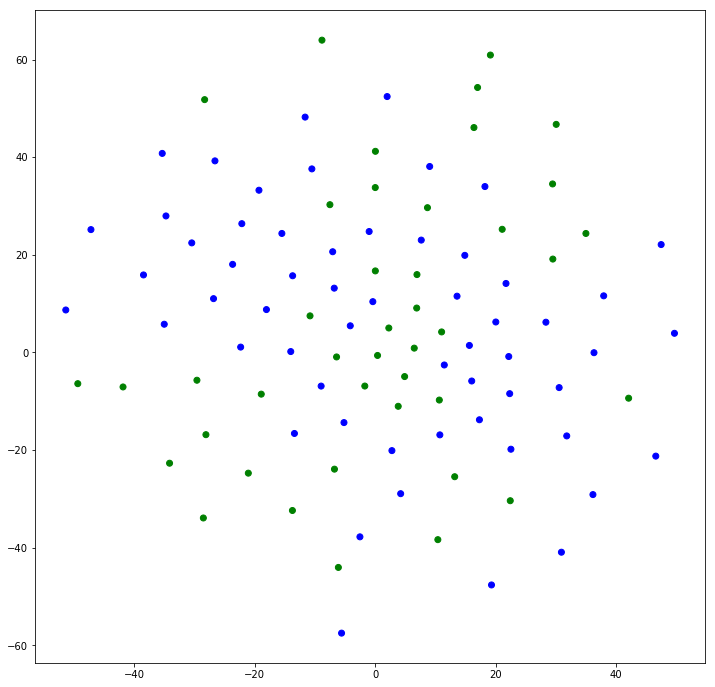

In [15]:
plot_vectors(train_vecs[:100], y_train)